In [5]:
# Import necessary libraries - common libraries include pandas, numpy, matplotlib, and sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib import gridspec
import math
import scipy.stats
from scipy.stats import dgamma
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

In [6]:
# Read in the Carbon West data file
spy = pd.read_csv('spy_Original.csv')

# View the first few rows of the dataset
spy.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1/29/1993,24.701669,24.701669,24.578775,24.684113,1003200,29,4,4,1,1993
1,2/1/1993,24.701643,24.859650,24.701643,24.859650,480500,1,0,5,2,1993
2,2/2/1993,24.842113,24.929895,24.789444,24.912338,201300,2,1,5,2,1993
3,2/3/1993,24.947451,25.193238,24.929894,25.175682,529400,3,2,5,2,1993
4,2/4/1993,25.263461,25.333686,24.982561,25.281017,531500,4,3,5,2,1993


In [7]:
spy.tail()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
7949,8/26/2024,563.179993,563.909973,559.049988,560.789978,35788600,26,0,35,8,2024
7950,8/27/2024,559.489990,562.059998,558.320007,561.559998,32693900,27,1,35,8,2024
7951,8/28/2024,561.210022,561.650024,555.039978,558.299988,41066000,28,2,35,8,2024
7952,8/29/2024,560.309998,563.679993,557.179993,558.349976,38715200,29,3,35,8,2024
7953,8/30/2024,560.770019,564.200012,557.140015,563.679993,62700100,30,4,35,8,2024


In [8]:
# check for null values and data type
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     7954 non-null   object 
 1   Open     7954 non-null   float64
 2   High     7954 non-null   float64
 3   Low      7954 non-null   float64
 4   Close    7954 non-null   float64
 5   Volume   7954 non-null   int64  
 6   Day      7954 non-null   int64  
 7   Weekday  7954 non-null   int64  
 8   Week     7954 non-null   int64  
 9   Month    7954 non-null   int64  
 10  Year     7954 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 683.7+ KB


In [9]:
# Convert the 'Date' column to a datetime format for proper date handling
spy['Date'] = pd.to_datetime(spy['Date'])

# Calculate the average 'Volume' prior to 2010 and post 2010
avg_volume_pre_2010 = spy[spy['Date'] < '2010-01-01']['Volume'].mean()
avg_volume_post_2010 = spy[spy['Date'] >= '2010-01-01']['Volume'].mean()

print("SPY AVG Volume Pior to 2010")
print(f"{avg_volume_pre_2010:.2f}")
print(' ')
print("SPY AVG Volume Post 2010")
print(f"{avg_volume_post_2010:.2f}")
print(' ')
print("SPY Volume Change Magnitude")
print(f"{avg_volume_post_2010 / avg_volume_pre_2010:.2f}")

SPY AVG Volume Pior to 2010
58690971.58
 
SPY AVG Volume Post 2010
113270950.27
 
SPY Volume Change Magnitude
1.93


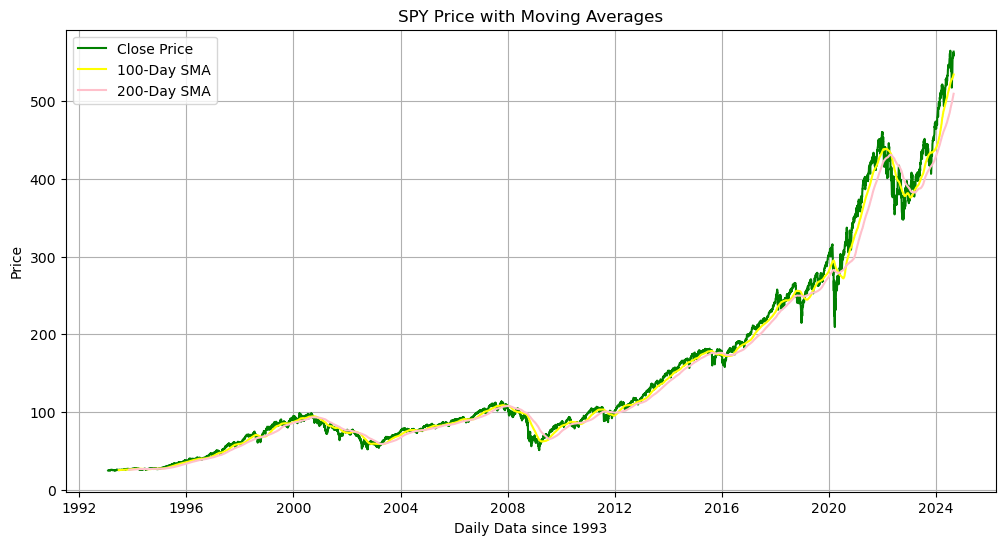

In [10]:
# set Date as the index
spy['Date_Index'] = pd.to_datetime(spy['Date'])  # Convert to datetime if not already
spy.set_index('Date_Index', inplace=True)  # Set 'Date' as the index
# Calculate the moving average
spy['SMA_100'] = spy['Close'].rolling(window=100).mean()
spy['SMA_200'] = spy['Close'].rolling(window=200).mean()

# plot spy performance since 2014 to visually trends and possible imbalances
plt.figure(figsize=(12, 6))
plt.plot(spy['Close'], label='Close Price', color='green')
plt.plot(spy['SMA_100'], label='100-Day SMA', color='yellow')
plt.plot(spy['SMA_200'], label='200-Day SMA', color='pink')
plt.title('SPY Price with Moving Averages')
plt.xlabel('Daily Data since 1993')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

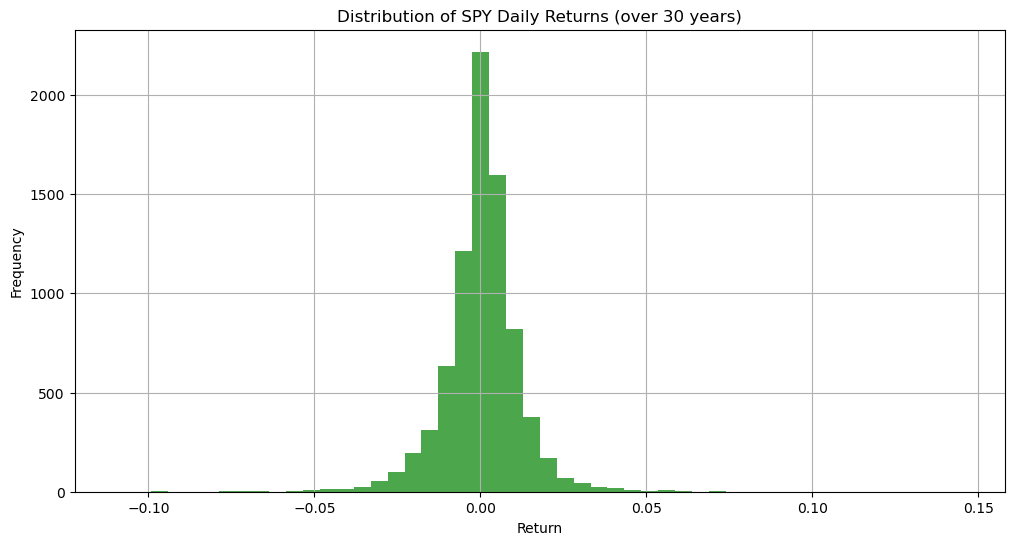

In [11]:
# plot distribution of returns
spy['Returns'] = spy['Close'].pct_change()

plt.figure(figsize=(12, 6))
plt.hist(spy['Returns'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Distribution of SPY Daily Returns (over 30 years)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [12]:
# Calculate daily returns using the 'Close' price
spy['Daily_Return'] = spy['Close'].pct_change() * 100

# Create subsets for the past 10 years and past 5 years
end_date = spy['Date'].max()
five_years_ago = end_date - pd.DateOffset(years=5)
ten_years_ago = end_date - pd.DateOffset(years=10)

spy_data_10y = spy[spy['Date'] >= ten_years_ago]
spy_data_5y = spy[spy['Date'] >= five_years_ago]

# New variables for skewness and kurtosis calculations
skewness_entire_dataset = skew(spy['Daily_Return'].dropna())
kurtosis_entire_dataset = kurtosis(spy['Daily_Return'].dropna())

skewness_last_10_years = skew(spy_data_10y['Daily_Return'].dropna())
kurtosis_last_10_years = kurtosis(spy_data_10y['Daily_Return'].dropna())

skewness_last_5_years = skew(spy_data_5y['Daily_Return'].dropna())
kurtosis_last_5_years = kurtosis(spy_data_5y['Daily_Return'].dropna())

# Display the results
print("Skewness and Kurtosis of SPY Daily Returns:")
print(f"Entire Dataset: Skewness = {skewness_entire_dataset:.2f}, Kurtosis = {kurtosis_entire_dataset:.2f}")
print(f"Past 10 Years: Skewness = {skewness_last_10_years:.2f}, Kurtosis = {kurtosis_last_10_years:.2f}")
print(f"Past 5 Years: Skewness = {skewness_last_5_years:.2f}, Kurtosis = {kurtosis_last_5_years:.2f}")

Skewness and Kurtosis of SPY Daily Returns:
Entire Dataset: Skewness = -0.06, Kurtosis = 11.38
Past 10 Years: Skewness = -0.54, Kurtosis = 12.69
Past 5 Years: Skewness = -0.55, Kurtosis = 11.79


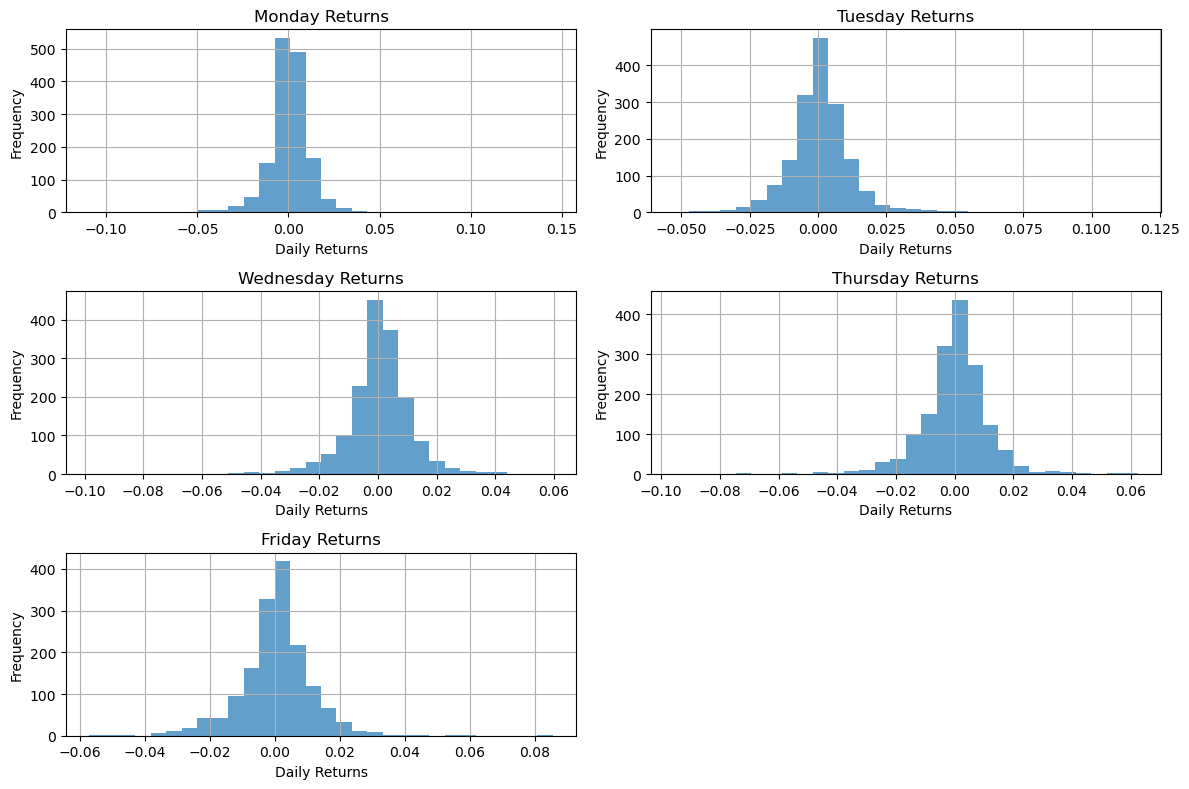

In [13]:
# Step 1: Calculate daily returns (if not already calculated)
spy['Daily_Returns'] = spy['Close'].pct_change()

# Step 2: Plot histograms for each day of the week using the existing 'Weekday' column (0 to 5)
# 0 = Monday, 5 = Friday
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.figure(figsize=(12, 8))
for i, day in enumerate(days):
    plt.subplot(3, 2, i+1)  # Create a subplot for each day
    spy[spy['Weekday'] == i]['Daily_Returns'].hist(bins=30, alpha=0.7)
    plt.title(f'{day} Returns')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

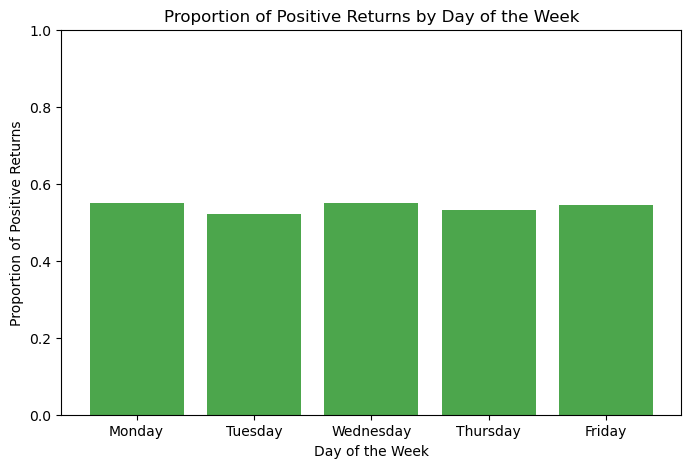

In [14]:
# Step 1: Calculate daily returns (if not already calculated)
spy['Daily_Returns'] = spy['Close'].pct_change()

# Step 2: Categorize returns as positive (1) or negative (0)
spy['Positive_Return'] = spy['Daily_Returns'] > 0

# Step 3: Calculate the proportion of positive returns for each day of the week using the existing 'Weekday' column
proportion_positive = spy.groupby('Weekday')['Positive_Return'].mean()

# Step 4: Plot the proportions
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.figure(figsize=(8, 5))
plt.bar(days, proportion_positive, color='green', alpha=0.7)
plt.title('Proportion of Positive Returns by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Proportion of Positive Returns')
plt.ylim(0, 1)  # Proportions are between 0 and 1
plt.show()

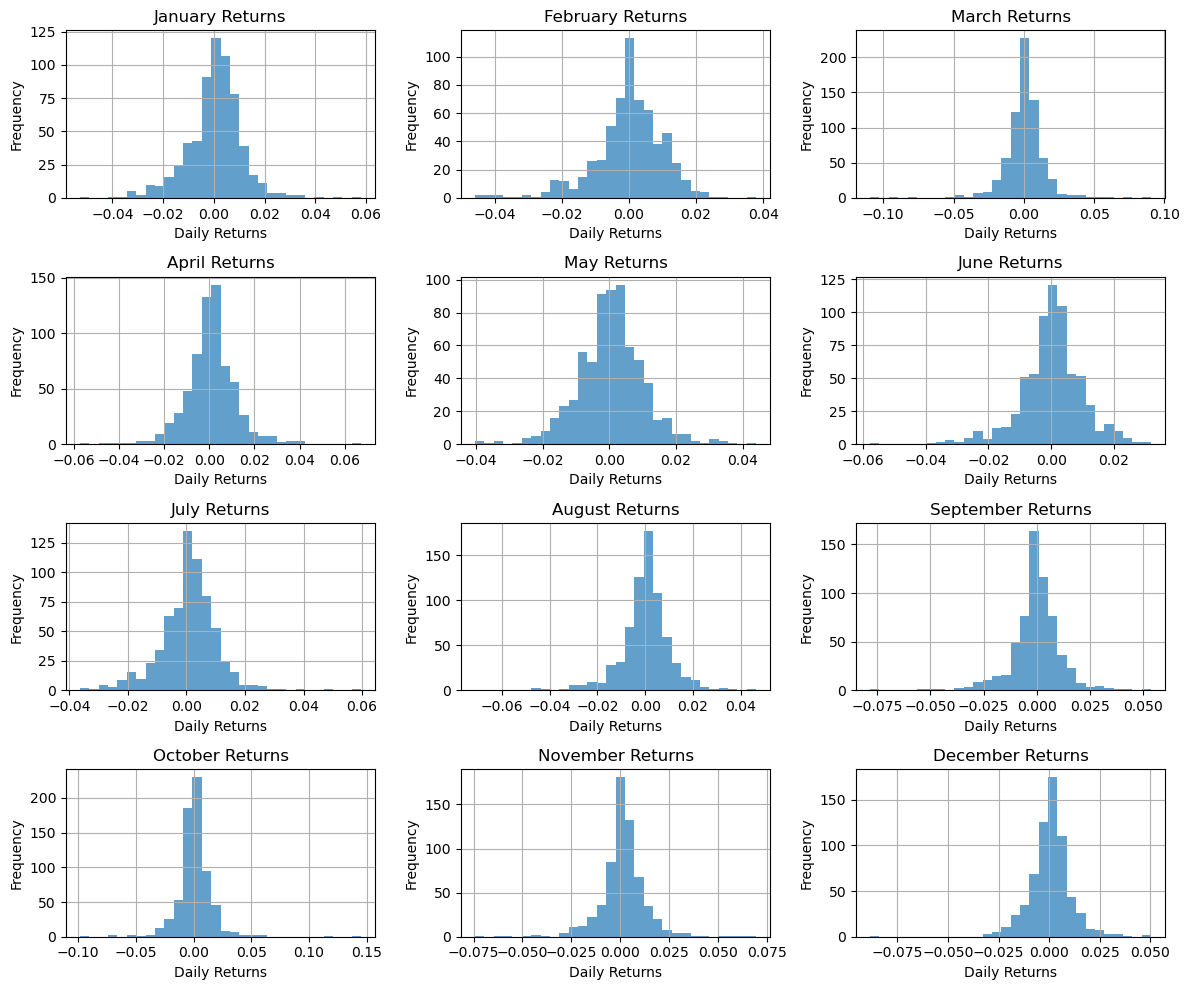

In [15]:
# Step 1: Calculate daily returns
spy['Daily_Returns'] = spy['Close'].pct_change()

# Step 3: Plot histograms of daily returns by month
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 10))
for i, month in enumerate(months):
    plt.subplot(4, 3, i+1)  # Create a subplot for each month
    spy[spy['Month'] == (i+1)]['Daily_Returns'].hist(bins=30, alpha=0.7)
    plt.title(f'{month} Returns')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

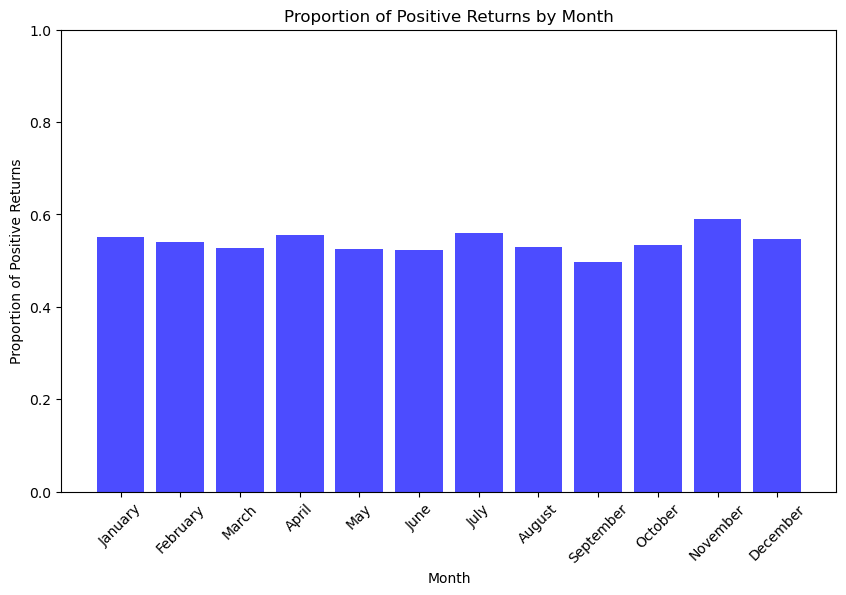

In [16]:
# Step 4: Categorize returns as positive (1) or negative (0)
spy['Positive_Return'] = spy['Daily_Returns'] > 0

# Step 5: Calculate the proportion of positive returns for each month
proportion_positive_month = spy.groupby('Month')['Positive_Return'].mean()

# Step 6: Plot the proportion of positive returns by month
plt.figure(figsize=(10, 6))
plt.bar(months, proportion_positive_month, color='blue', alpha=0.7)
plt.title('Proportion of Positive Returns by Month')
plt.xlabel('Month')
plt.ylabel('Proportion of Positive Returns')
plt.ylim(0, 1)  # Proportions are between 0 and 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [17]:
# Step 1: Create the binary target variable (1 if Close > Open, else 0)
spy['Outcome'] = (spy['Close'] > spy['Open']).astype(int)

# Step 2: Choose features and target variable
X = spy[['Open', 'High', 'Low', 'Volume']]
y = spy['Outcome']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Confusion Matrix:")
print(conf_matrix)

Logistic Regression Accuracy: 0.7706
Logistic Regression Confusion Matrix:
[[456 284]
 [ 81 770]]


In [18]:
# Step 1: Create the binary target variable (1 if Close > Open, else 0)
spy['Outcome'] = (spy['Close'] > spy['Open']).astype(int)

# Create Exponential Moving Averages (EMA)
spy['EMA_5'] = spy['Close'].ewm(span=5, adjust=False).mean()
spy['EMA_10'] = spy['Close'].ewm(span=10, adjust=False).mean()
spy['EMA_20'] = spy['Close'].ewm(span=20, adjust=False).mean()

# Create rolling standard deviation for volatility
spy['Volatility_5'] = spy['Close'].rolling(window=5).std()
spy['Volatility_10'] = spy['Close'].rolling(window=10).std()

# Caclulate Volume moving average
spy['Vol_MA_5'] = spy['Volume'].rolling(window=5).mean()
spy['Vol_MA_10'] = spy['Volume'].rolling(window=10).mean()

# Calculate Day of the Month
spy['Day_of_Month'] = pd.to_datetime(spy['Date']).dt.day

#  Starting Features
spy['Range'] = spy['High'] - spy['Low']  # Add the daily range
spy['Prev_Close'] = spy['Close'].shift(1)  # Previous day's close
spy['Prev_Open'] = spy['Open'].shift(1) # next day's open
spy['Intra_Move'] = spy['Prev_Close'] - spy['Prev_Open'] # get the previous day intraday move
spy['Prev_Volume'] = spy['Volume'].shift(1) # Previous day's volume
spy['Prev_Return'] = (spy['Prev_Close'] - spy['Prev_Open']) / spy['Prev_Open']  # Previous day's Intraday return
spy['Day_of_Week'] = pd.to_datetime(spy['Date']).dt.dayofweek # Add the day-of-week as a feature (0 for Monday, 4 for Friday, etc.)
spy['Month'] = pd.to_datetime(spy['Date']).dt.month # Extract the month from the Date column and add it as a feature

# Check the return from 2 days ago
spy['Lag_Return_2'] = spy['Prev_Return'].shift(1)

# Fill any missing values from shifting
spy.fillna(0, inplace=True)

# Define Features to use in model
X = spy[['Open', 'High', 'Low', 'Prev_Close', 'Prev_Volume', 'Prev_Return',
         'Day_of_Week', 'Intra_Move', 'EMA_5', 'EMA_10', 'EMA_20']]
y = spy['Outcome']

# Step 2: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
# This allows us to handle imbalanced datasets which SPY is because over time it tends to increase
# SMOTE generates synthetic samples of the minority class to balance the dataset
smote = SMOTE(random_state=42)
# Fit the SMOTE algorithm to data set and resamples x_scaled and y to make both classes balanced
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 4: Split the resampled data into training and testing sets
# split data by 80/20, train on 80% and test on 20%
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Train the logistic regression model with class weights to balance classes
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
grid_search = GridSearchCV(log_reg, param_grid, cv=5)

# Train the model with grid search
# log_reg.fit(X_train, y_train)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_log_reg = grid_search.best_estimator_

# Step 6: Make predictions on the test set
#y_pred = log_reg.predict(X_test)
# Make predictions with the best model
y_pred = best_log_reg.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Confusion Matrix:")
print(conf_matrix)

Logistic Regression Accuracy: 0.8433
Logistic Regression Confusion Matrix:
[[711 115]
 [146 694]]


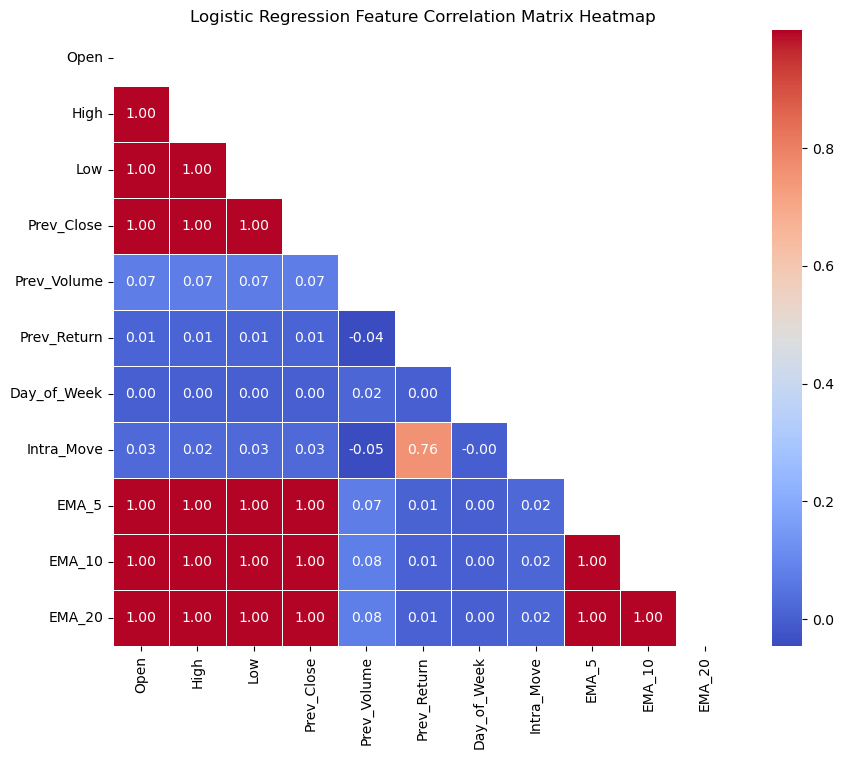

In [19]:
# Run correlation on the features
correlation_matrix = X.corr()

# mask duplicate values on heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Logistic Regression Feature Correlation Matrix Heatmap')
plt.show()

In [20]:
# Extract the values
TN, FP, FN, TP = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]

# Calculating Precision, Recall, and F1-score manually
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8578
Recall: 0.8262
F1-score: 0.8417


In [21]:
# Add a constant for the intercept term
X_resampled_with_const = sm.add_constant(X_resampled)

# Perform logistic regression using statsmodels to get the p-values for the Wald test
logit_model = sm.Logit(y_resampled, X_resampled_with_const)
result = logit_model.fit()

# Get the summary of the model which includes the Wald test results (p-values)
summary = result.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.359599
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                 8328
Model:                          Logit   Df Residuals:                     8316
Method:                           MLE   Df Model:                           11
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.4812
Time:                        11:45:46   Log-Likelihood:                -2994.7
converged:                       True   LL-Null:                       -5772.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0261      0.043      0.608      0.543      -0.058       0.110
x1          -666.7706     17

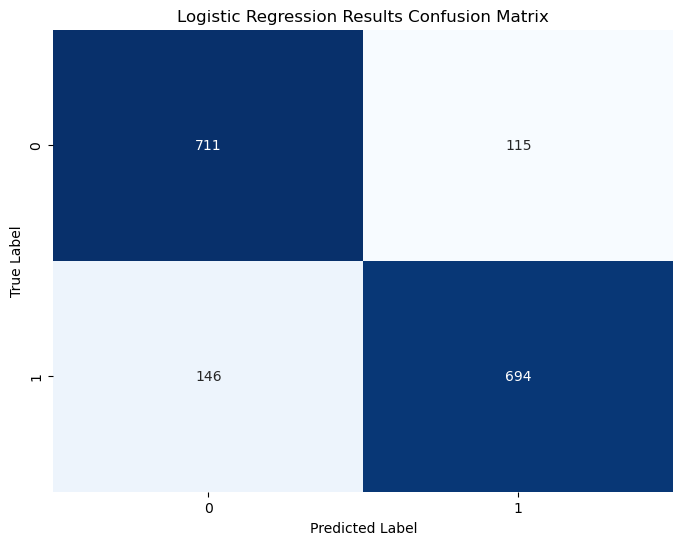

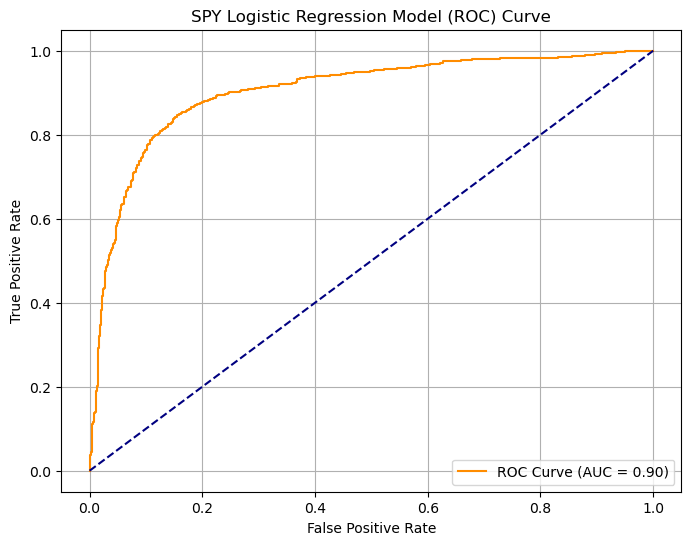

In [22]:
# Visualize confusion matrix from Logistic Regression
# Step 1: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Logistic Regression Results Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 2: Plot ROC Curve
y_prob = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SPY Logistic Regression Model (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import numpy as np

# Define the models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(),
    "Grandient Boosting": GradientBoostingClassifier(),
    # removing Neural Network due to slow processing and resource requirements
    #"Neural Network": MLPClassifier(),
    
}

# add key metrics to the cross validation for further comparison
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Perform 5-fold cross-validation for each model
results = {}
for model_name, model in models.items():
    # Create a pipeline with SMOTE and the model
    pipeline = Pipeline([
        ('smote', SMOTE()),  # Apply SMOTE
        ('scaler', StandardScaler()),  # Scale features (if necessary)
        ('model', model)
    ])
    # Cross-validate the model using accuracy as the metric
    scores = cross_validate(pipeline, X_scaled, y, cv=5, scoring=scoring)

    # store key metrics
    results[model_name] = {
        'accuracy_mean': np.mean(scores['test_accuracy']),
        'precision_mean': np.mean(scores['test_precision']),
        'recall_mean': np.mean(scores['test_recall']),
        'f1_mean': np.mean(scores['test_f1']),
    }

# Print the summary of results
    print(f"{model_name}:")
    print(f"  Accuracy: {results[model_name]['accuracy_mean']:.4f}")
    print(f"  Precision: {results[model_name]['precision_mean']:.4f}")
    print(f"  Recall: {results[model_name]['recall_mean']:.4f}")
    print(f"  F1-Score: {results[model_name]['f1_mean']:.4f}")


Logistic Regression:
  Accuracy: 0.5790
  Precision: 0.7198
  Recall: 0.4555
  F1-Score: 0.4308
Decision Tree:
  Accuracy: 0.4630
  Precision: 0.4708
  Recall: 0.4552
  F1-Score: 0.4508
Grandient Boosting:
  Accuracy: 0.4561
  Precision: 0.4737
  Recall: 0.4256
  F1-Score: 0.3816


In [35]:
# Define a function to randomly sample values from the dataset and use them in the prediction model
def random_sample_prediction(spy, model, scaler):
    # Step 1: Randomly sample one row from the dataset
    random_sample = spy.sample(1)
    
    # Step 2: Extract features required for the prediction
    random_sample_data = random_sample[['Open', 'High', 'Low', 'Prev_Close', 'Prev_Volume', 'Prev_Return',
                                        'Day_of_Week', 'Intra_Move', 'EMA_5', 'EMA_10', 'EMA_20']]
    
    # Step 3: Scale the features using the existing scaler
    random_sample_scaled = scaler.transform(random_sample_data)
    
    # Step 4: Make a prediction using the trained logistic regression model
    prediction = model.predict(random_sample_scaled)
    prediction_proba = model.predict_proba(random_sample_scaled)
    
    # Step 5: Return the prediction and probabilities
    result = {
        'Sampled Data': random_sample_data,
        'Prediction': 'Close > Open' if prediction[0] == 1 else 'Close <= Open',
        'Probability (Close > Open)': prediction_proba[0][1],
        'Probability (Close <= Open)': prediction_proba[0][0]
    }
    
    return result

# Run the random sampling prediction using the current dataset, trained model, and scaler
random_sample_result = random_sample_prediction(spy, best_log_reg, scaler)
random_sample_result

{'Sampled Data':                   Open        High         Low  Prev_Close  Prev_Volume  \
 Date_Index                                                                
 2013-05-03  131.580749  132.185009  130.470225  130.445724   96407600.0   
 
             Prev_Return  Day_of_Week  Intra_Move      EMA_5      EMA_10  \
 Date_Index                                                                
 2013-05-03     0.006743            4    0.873727  130.46116  129.747902   
 
                 EMA_20  
 Date_Index              
 2013-05-03  128.923257  ,
 'Prediction': 'Close > Open',
 'Probability (Close > Open)': 0.5225098888003706,
 'Probability (Close <= Open)': 0.47749011119962936}

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def process_and_train_model(file_path):
    # Load the data from the file path
    spy = pd.read_csv(file_path)

    # Step 1: Create the binary target variable (1 if Close > Open, else 0)
    spy['Outcome'] = (spy['Close'] > spy['Open']).astype(int)

    # Create Exponential Moving Averages (EMA)
    spy['EMA_5'] = spy['Close'].ewm(span=5, adjust=False).mean()
    spy['EMA_10'] = spy['Close'].ewm(span=10, adjust=False).mean()
    spy['EMA_20'] = spy['Close'].ewm(span=20, adjust=False).mean()

    # Create rolling standard deviation for volatility
    spy['Volatility_5'] = spy['Close'].rolling(window=5).std()
    spy['Volatility_10'] = spy['Close'].rolling(window=10).std()

    # Calculate Volume moving average
    spy['Vol_MA_5'] = spy['Volume'].rolling(window=5).mean()
    spy['Vol_MA_10'] = spy['Volume'].rolling(window=10).mean()

    # Calculate Day of the Month
    spy['Day_of_Month'] = pd.to_datetime(spy['Date']).dt.day

    # Feature Engineering
    spy['Range'] = spy['High'] - spy['Low']  # Add the daily range
    spy['Prev_Close'] = spy['Close'].shift(1)  # Previous day's close
    spy['Prev_Open'] = spy['Open'].shift(1)  # Next day's open
    spy['Intra_Move'] = spy['Prev_Close'] - spy['Prev_Open']  # Get the previous day intraday move
    spy['Prev_Volume'] = spy['Volume'].shift(1)  # Previous day's volume
    spy['Prev_Return'] = (spy['Prev_Close'] - spy['Prev_Open']) / spy['Prev_Open']  # Previous day's Intraday return
    spy['Day_of_Week'] = pd.to_datetime(spy['Date']).dt.dayofweek  # Add the day-of-week as a feature
    spy['Month'] = pd.to_datetime(spy['Date']).dt.month  # Extract the month from the Date column
    # Check the return from 2 days ago
    spy['Lag_Return_2'] = spy['Prev_Return'].shift(1)
    
    # Fill any missing values from shifting
    spy.fillna(0, inplace=True)

    # Define Features to use in model
    X = spy[['Open', 'High', 'Low', 'Prev_Close', 'Prev_Volume', 'Prev_Return',
             'Day_of_Week', 'Intra_Move', 'EMA_5', 'EMA_10', 'EMA_20']]
    y = spy['Outcome']

    # Step 2: Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Handle class imbalance using the built-in balanced class weights
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Step 4: Train the logistic regression model with grid search
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
    grid_search = GridSearchCV(log_reg, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_log_reg = grid_search.best_estimator_

    # Step 5: Make predictions on the test set
    y_pred = best_log_reg.predict(X_test)

    # Step 6: Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Return the accuracy, confusion matrix, and trained model
    return accuracy, conf_matrix, best_log_reg, scaler


Accuracy: 0.8444
Confusion Matrix:
[[373  67]
 [ 71 376]]


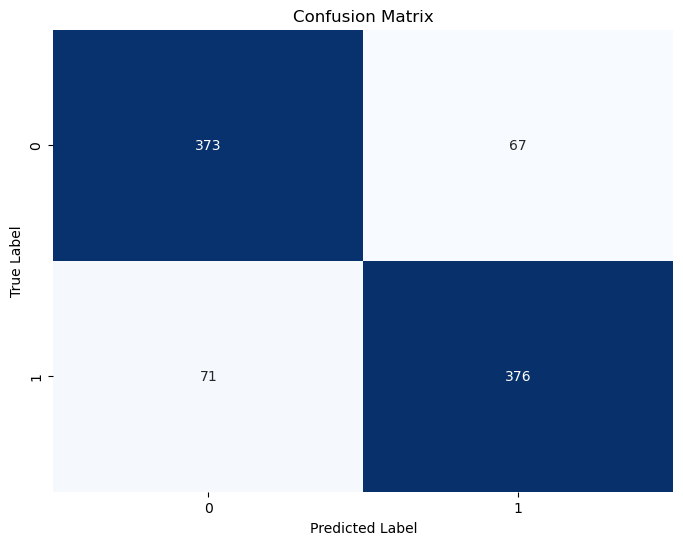

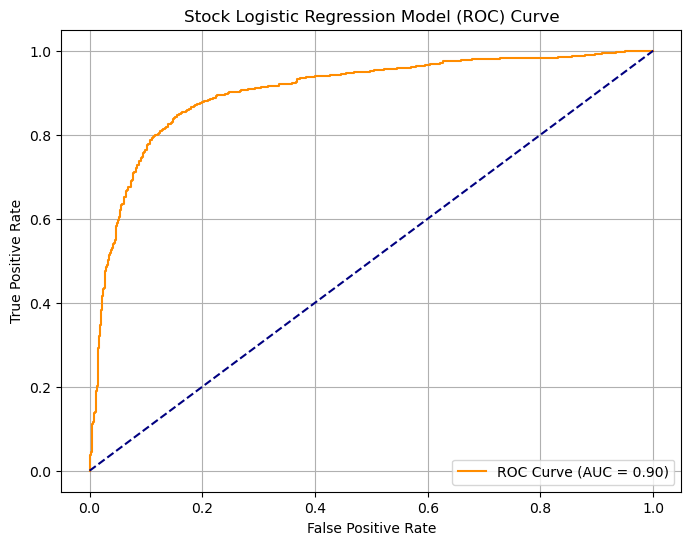

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Call the function with your data file
file_path = 'GOOGL.csv'
accuracy, conf_matrix, trained_model, scaler = process_and_train_model(file_path)

# Display accuracy and confusion matrix
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix from Logistic Regression
# Step 1: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 2: Plot ROC Curve
y_prob = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stock Logistic Regression Model (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()



In [38]:
# Extract the values
TN, FP, FN, TP = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]

# Calculating Precision, Recall, and F1-score manually
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8488
Recall: 0.8412
F1-score: 0.8449
